# Automatic classification of seismic P-wave receiver functions using Random Forests (RF)

Train Random Forests to automatically classify the seismic P-wave receiver functions, one on logistic regression and the other one on decision trees.

The goal is to classify the P-wave receiver functions, which were computed based on the recorded seismic data, into two categories: good and bad. The entire data set consists of 12,597 receiver functions (i.e., seismic traces), each of which was visually examined and manually labeled as either good or bad by one of Prof. Aibing Li's PhD students, Ying Zhang, in the Department of Earth and Atmospheric Sciences at University of Houston. The good seismic traces are labled (or, encoded) as 1, and bad seismic traces are encoded as 0. <br>



## 2. Import data
Import the amplitude data and the labels from *Traces_qc.mat*. Be sure to store the seismic amplitudes from all seismic stations into the varible **amp_data**, and the labels for all the seismic traces into the variable **label_data**. 


Download the Traces dataset at https://drive.google.com/file/d/1vSBcmbga-o8Eti1e5S08LwPD0hCmjL2c/view?usp=share_link

In [1]:
import numpy as np
import h5py  # The h5py package is a Pythonic interface to the HDF5 binary data format. https://www.h5py.org/
with h5py.File("./Traces_qc.mat") as f:
    # note that we are using the data file from your Lab 3. This is to save some space for your Google Drive. So, plese be sure that your Lab 3 folder contain Traces_qc.mat.
    ampdata = [f[element[0]][:] for element in f["Data"]["amps"]]
    flag = [f[element[0]][:] for element in f["Data"]["Flags"]]
    ntr = [f[element[0]][:] for element in f["Data"]["ntr"]]
    time = [f[element[0]][:] for element in f["Data"]["time"]]
    staname = [f[element[0]][:] for element in f["Data"]["staname"]]
    
ampall = np.zeros((1,651))
flagall = np.zeros(1)
for i in np.arange(201):
    ampall = np.vstack((ampall, ampdata[i]))
    flagall = np.vstack((flagall, flag[i]))
amp_data = np.delete(ampall, 0, 0)
label_data = np.delete(flagall, 0, 0)

In [2]:
print('The total of bad seismic traces is:', len(np.where(label_data==0)[0]))
print('The total of good seismic traces is:', len(np.nonzero(label_data)[0]))

The total of bad seismic traces is: 9632
The total of good seismic traces is: 2965


## 3. Preprocessing data
Get the data ready for the subsequent analysis or computations. The most common preprocessing step in machine learning is to [standardize features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) by removing the mean and scaling to unit variance. <br>
<br>


In [3]:
np.random.seed(42)
all_data = np.append(amp_data,label_data,1) # put all the seismic traces and their lables into one matrix.

Randomly permute the data stored in the variable **all_data** using <font color=blue>**np.random.permutation**</font>, and store the permuted data in a new variable **all_data_permute**. 

In [4]:
all_data_permute = all_data[np.random.permutation(all_data.shape[0]),:] 

## 4. Split data into training and cross-validation sets
Use the first 10,000 seismic traces as out training data set, and the rest 2,597 traces as test dat set.

In [5]:
X_train = all_data_permute[:10000,:-1]
y_train = all_data_permute[:10000,-1]

X_validation = all_data_permute[10000:,:-1]
y_validation = all_data_permute[10000:,-1]

Note that, in Scikit-learn, there is a convenient way of splitting the data by using the [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) module, which is widely used in practice. To keep things consistent, and more importantly, to keep the comparison of the prediction accuracies from different ML algorithms fair, I manually split the whole set of data into a training and validation set.

## 5. Import and set up RF classifer
Import [**RandomForestClassifier**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from Scikit-Learn. Set up your RandomForestClassifier by setting **n_estimators = 100**, **max_depth = 10**, **random_state = 42**, and **class_weight = 'balanced_subsample'**, and assign this classifier to a new variable **rf_clf**.


In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42,class_weight='balanced_subsample')

## 6. Train a RF model
Train a RF model using the **training** data set, <font color=blue>**X_train**</font> and <font color=blue>**y_train**</font>, and the classifier, <font color=blue>**rf_clf**</font>, you set up above.
<br>


In [7]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       random_state=42)

## 7. Evaluation
Make predictions on the <font color=blue>**validation**</font> data set, and assign the predictions to a new variable, **y_pred**. <br>

In [8]:
y_pred = rf_clf.predict(X_validation)

Import **classification_report** from **sklearn.metrics**. Print out the classification report. 


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_validation,y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      1994
         1.0       0.66      0.85      0.74       603

    accuracy                           0.86      2597
   macro avg       0.81      0.86      0.83      2597
weighted avg       0.88      0.86      0.87      2597



Feature ranking:
1. feature 49 (0.072604)
2. feature 47 (0.057146)
3. feature 48 (0.052083)
4. feature 50 (0.048997)
5. feature 51 (0.047240)
6. feature 52 (0.046064)
7. feature 53 (0.041756)
8. feature 54 (0.026702)
9. feature 46 (0.024174)
10. feature 55 (0.023600)


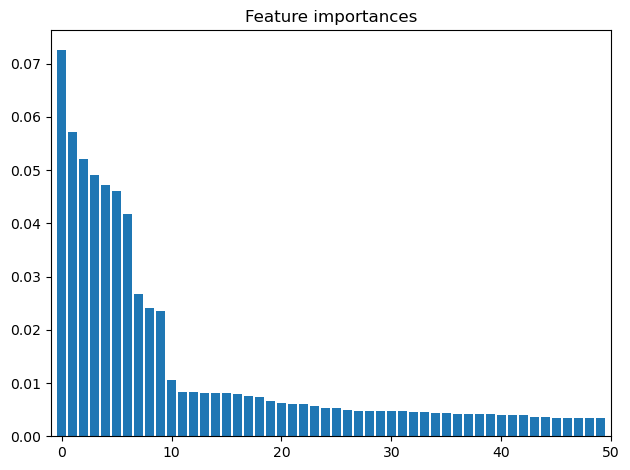

In [14]:
# The following code is based on a modification of the codes in this webpage
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(50), importances[indices][:50])
# plt.xticks(range(50), indices, rotation = 90)
plt.xlim([-1, 50])
plt.tight_layout()
plt.show()

In [15]:
# The prediction error on training data
1 - rf_clf.score(X_train, y_train)

0.07669999999999999

In [20]:
# The prediction error on validation data
print(1-rf_clf.score(X_validation,y_validation))

0.13554100885637277


## 8. Construct error curves
Construct error curves by training a sequence of Random Forests.

In [21]:
train_errors = np.zeros(25)
validation_errors = np.zeros(25)

In [22]:
for idepth in np.arange(1,26):
    print('Random Forest with max_depth = ', idepth)
    # set up RandomForestClassifier. Hint: max_depth = idepth.
    rf_clf = RandomForestClassifier(n_estimators=100,max_depth=idepth,random_state=42,class_weight='balanced_subsample')
    
    # perform training using training data
    rf_clf.fit(X_train,y_train)
    
    # make predictions using validation data
    y_pred = rf_clf.predict(X_validation)
    
    # save prediction errors to train_errors, and validation_errors
    train_errors[idepth-1] = 1 - rf_clf.score(X_train, y_train)
    validation_errors[idepth-1]= 1 - rf_clf.score(X_validation,y_validation)

Random Forest with max_depth =  1
Random Forest with max_depth =  2
Random Forest with max_depth =  3
Random Forest with max_depth =  4
Random Forest with max_depth =  5
Random Forest with max_depth =  6
Random Forest with max_depth =  7
Random Forest with max_depth =  8
Random Forest with max_depth =  9
Random Forest with max_depth =  10
Random Forest with max_depth =  11
Random Forest with max_depth =  12
Random Forest with max_depth =  13
Random Forest with max_depth =  14
Random Forest with max_depth =  15
Random Forest with max_depth =  16
Random Forest with max_depth =  17
Random Forest with max_depth =  18
Random Forest with max_depth =  19
Random Forest with max_depth =  20
Random Forest with max_depth =  21
Random Forest with max_depth =  22
Random Forest with max_depth =  23
Random Forest with max_depth =  24
Random Forest with max_depth =  25


In [23]:
print("The minimum validation error is : ", min(validation_errors))
print("The best prediction arracy is:", 1 - min(validation_errors))

best_depth = np.argmin(validation_errors) + 1
print("The minimum validation error (i.e., the best prediction accuracy) occurs when max_depth = ", best_depth)

The minimum validation error is :  0.10165575664227955
The best prediction arracy is: 0.8983442433577205
The minimum validation error (i.e., the best prediction accuracy) occurs when max_depth =  22


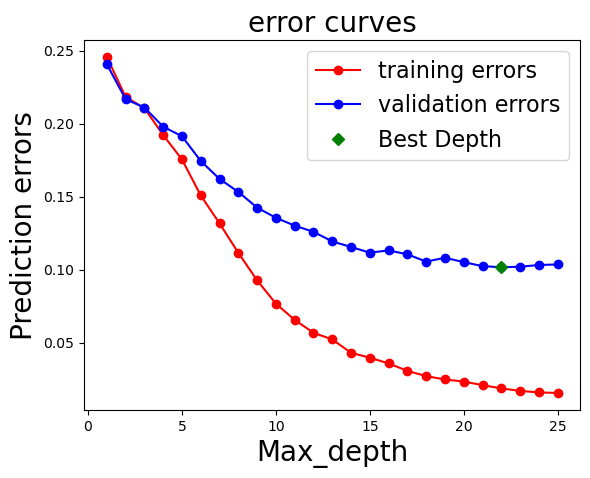

In [24]:
max_depth =  np.arange(1,26)
plt.plot(max_depth,train_errors,'-ro',label="training errors")
plt.plot(max_depth,validation_errors,'-bo',label="validation errors")
plt.plot(best_depth,validation_errors[best_depth-1],'gD',label="Best Depth")
#plt.plot([best_depth,best_depth],[0,validation_errors[best_depth-1]],'g-')
plt.title('error curves',fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.xlabel("Max_depth", fontsize=20)
plt.ylabel("Prediction errors", fontsize=20, rotation=90)
plt.show()

## 9. Applications of Random Forests to geoscience 

## Automatic classification of endogenous landslide seismicity using the Random Forest supervised classifier

[AGU](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL070709)

Deformation of slow moving landslides in clays induces endogenous seismicity of low magnitude seismic events. Long records are needed to identify the seismic sources and understand the mechanisms, which would be intensly time consuming to classify by hand. The authors propose using automatic classification based on the computaion of 71 seismic attributes using a random forrest supervised classifier. The authors report the random forrest classifier retrieves 93% of sensitivity when compared to a manually interpreted catalog.

## Uranium anomalies detection through Random Forest regression

[Exploration Geophysics](https://www.tandfonline.com/doi/abs/10.1080/08123985.2020.1725387)

The authors propose using a new method to detect uranium through airborne surveys through regression using the Random Forrest algorithm. A random selection of 10% of the database is used as the training data, they estimate the expected uranium with an $R^2 = 0.99$ compared to the measured uranium. The conclusion is the deviation between measured uranium and expected uranium to represent secondary effects such as weather, soil alteration, and other local effects.

## Acknowledgments
I would like to thank Ying Zhang for manually labeling all the seismic traces, and Prof. Aibing Li for making this data set available to the students in this class. Ms. Zhang also kindly explained the fundamentals of seismic P-wave receiver functions. 

<img src = "https://drive.google.com/uc?id=1vk_r0_eHQO9PfHY3D6L4_zQ8DUFVg4hJ" width="600">
